In [109]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as mp
import time

In [110]:
nanos_to_seconds = 1/1e6

dete_temp = np.genfromtxt('data/detectorTemp.txt', delimiter=',') #import delimited data
dete_temp = dete_temp[1:] #trim off nans created from lable line
dete_temp[:,0] = dete_temp[:,0]*nanos_to_seconds

dist_dopp = np.genfromtxt('data/distanceAndDoppler.txt', delimiter=',') #import delimited data
dist_dopp = dist_dopp[1:] #trim off nans created from lable line
dist_dopp[:,0] = dist_dopp[:,0]*nanos_to_seconds

inst_tele = np.genfromtxt('data/instrumentTelemetry.txt', delimiter=',') #import delimited data
inst_tele = inst_tele[1:] #trim off nans created from lable line
inst_tele[:,0] = inst_tele[:,0]*nanos_to_seconds

inte_time = np.genfromtxt('data/integrationTime.txt', delimiter=',') #import delimited data
inte_time = inte_time[1:] #trim off nans created from lable line
inte_time[:,0] = inte_time[:,0]*nanos_to_seconds

# plans = np.genfromtxt('lasp_dsse_hw/data/plans.txt', delimiter=',') #import delimited data
# plans = plan[1:] #trim off nans created from lable line

refe_spec = np.genfromtxt('data/referenceSpectrum.txt', delimiter=',') #import delimited data
refe_spec = refe_spec[1:] #trim off nans created from lable line


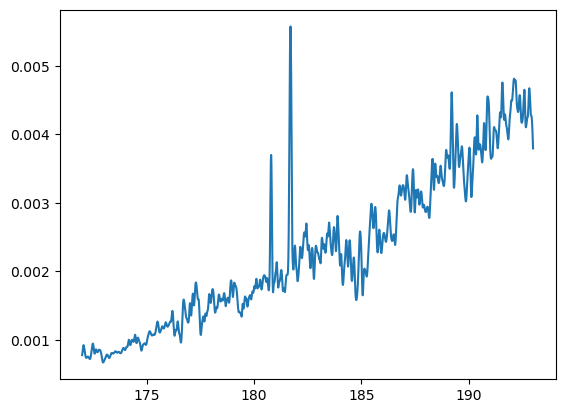

4201


In [111]:
mp.plot(refe_spec[:,0],refe_spec[:,1]) #glance at the refernce spectrum to check sanity
#looks like the spectrum is binned by pixels, since this sensor isn't working from hard gamma rays to heat IR.
#todo calc wavelength values for the refernce, so we can have values for data after fitting.
mp.show()

print(len(refe_spec[:,0]))

down time seconds: 4422.25
dark time seconds: 4413.439999938011
up time seconds: 4404.120000004768
down samples: 2527
dark samples: 4414
up samples: 2517


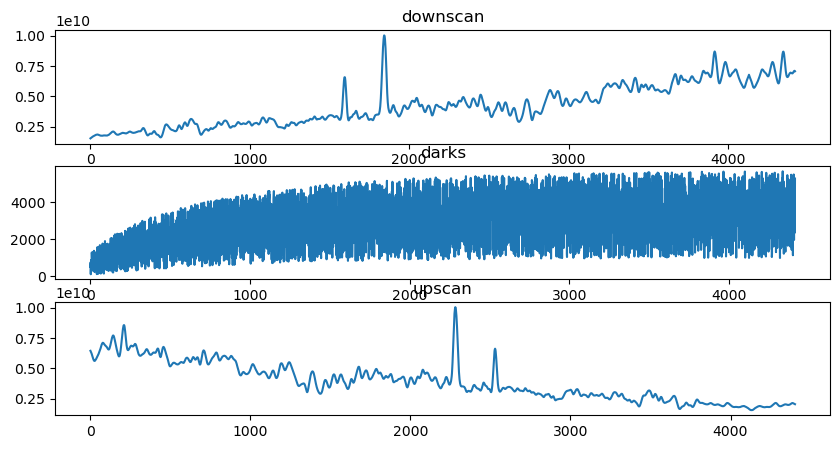

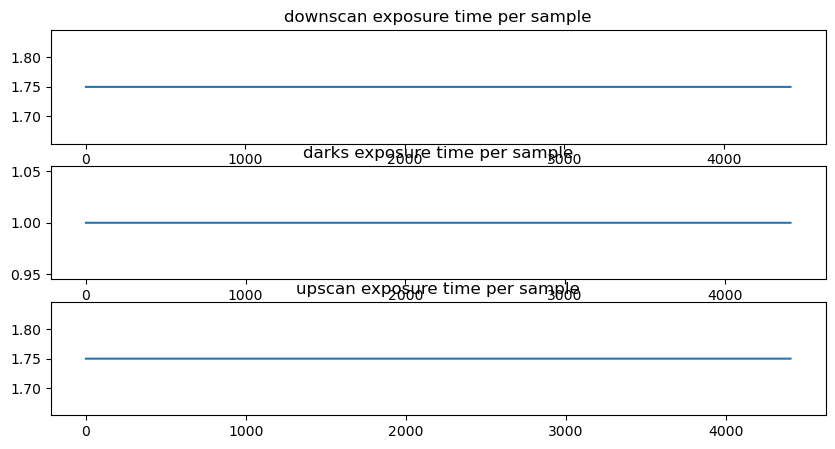

In [112]:
#let's find out what's inside the telemetry
#planName, startTime, endTime #all in µs
#DownScan, 9.434134508500002E14, 9.434178731000002E14
#Dark, 9.434192873600002E14, 9.434237008000002E14
#UpScan, 9.434251237500002E14, 9.434295278700002E14
# we are interested in the "plan" which starts at 9.434134508500002E14
down_start_time = 9.434134508500002e8
down_end_time = 9.434178731000002e8
print("down time seconds: "+str((down_end_time-down_start_time)))
dark_start_time = 9.434192873600002e8
dark_end_time = 9.434237008000002e8
print("dark time seconds: "+str((dark_end_time-dark_start_time)))
up_start_time = 9.434251237500002e8
up_end_time = 9.434295278700002e8
print("up time seconds: "+str((up_end_time-up_start_time)))

data_end_time = 9.434295267500002E14 #instrument telemetry ends at 9.434295267500002E14, which isn't the end of the upscan planned time, so that's a thing to figure out.

down_start = np.where (inst_tele[:,0]>=down_start_time)[0][0]
down_end = np.where (inst_tele[:,0]>=down_end_time)[0][0]
print("down samples: "+str(down_end-down_start))
dark_start = np.where (inst_tele[:,0]>=dark_start_time)[0][0]
dark_end = np.where (inst_tele[:,0]>=dark_end_time)[0][0]
print("dark samples: "+str(dark_end-dark_start))
up_start = np.where (inst_tele[:,0]>=up_start_time)[0][0]
up_end = len(inst_tele[:,0]) #np.where (inst_tele[:,0]==up_end_time)[0][0] #this breaks, looks like the data ends before the plan does.
print("up samples: "+str(up_end-up_start))

#we got lucky that "==" worked, though we could have done ">" and taken the first element of the output array.

# mp.figure(figsize=(9,3))
# mp.title('microsecondsSinceGpsEpoch per data point')
# mp.plot(inst_tele[down_start:up_end-1,0]-down_start_time,np.diff(inst_tele[down_start:up_end,0]))
# mp.show()

# mp.figure(2,figsize=(9,3))
fig, axs = mp.subplots(3,1, figsize=(10,5))
axs[0].plot(inst_tele[down_start:down_end,0]-down_start_time, inst_tele[down_start:down_end,2])
axs[0].title.set_text('downscan')
axs[1].plot(inst_tele[dark_start:dark_end,0]-dark_start_time, inst_tele[dark_start:dark_end,2])
axs[1].title.set_text('darks')
axs[2].plot(inst_tele[up_start:up_end,0]-up_start_time, inst_tele[up_start:up_end,2])
axs[2].title.set_text('upscan')
# fig.show()

# mp.figure(2,figsize=(9,3))
fig, axs = mp.subplots(3,1, figsize=(10,5))
axs[0].plot(inst_tele[down_start:down_end-1,0]-down_start_time, np.diff(inst_tele[down_start:down_end,0]))
axs[0].title.set_text('downscan exposure time per sample')
axs[1].plot(inst_tele[dark_start:dark_end-1,0]-dark_start_time, np.diff(inst_tele[dark_start:dark_end,0]))
axs[1].title.set_text('darks exposure time per sample')
axs[2].plot(inst_tele[up_start:up_end-1,0]-up_start_time, np.diff(inst_tele[up_start:up_end,0]))
axs[2].title.set_text('upscan exposure time per sample')

# fig.show()

down time seconds: 4422.25
dark time seconds: 4413.439999938011
up time seconds: 4404.120000004768
down samples: 4422
dark samples: 4414
up samples: 4405
rough estimate of sunlight temp delta: 2.9059364733850934


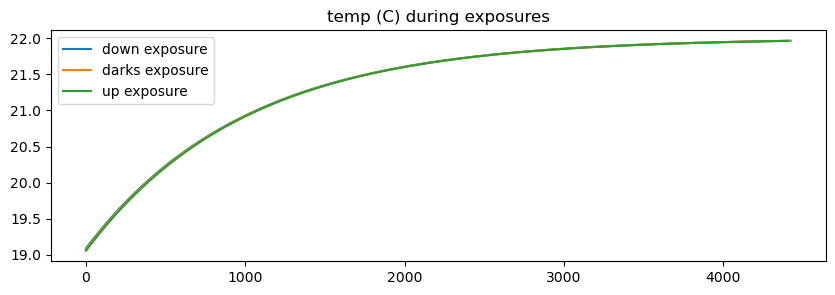

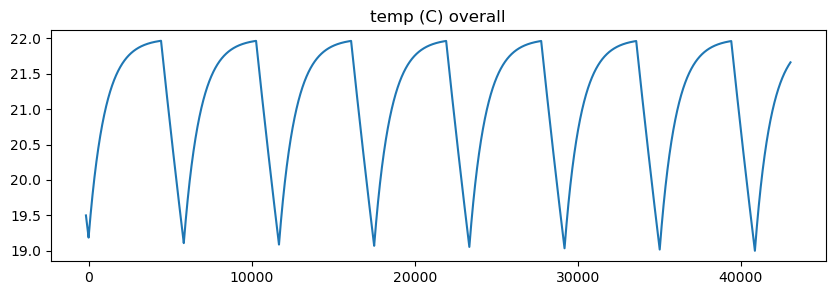

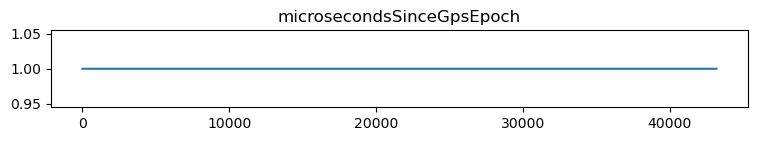

In [157]:
down_start_time = 9.434134508500002e8
down_end_time = 9.434178731000002e8
print("down time seconds: "+str((down_end_time-down_start_time)))
dark_start_time = 9.434192873600002e8
dark_end_time = 9.434237008000002e8
print("dark time seconds: "+str((dark_end_time-dark_start_time)))
up_start_time = 9.434251237500002e8
up_end_time = 9.434295278700002e8
print("up time seconds: "+str((up_end_time-up_start_time)))

down_start_temp = np.where (dete_temp[:,0]>=down_start_time)[0][0]
down_end_temp = np.where (dete_temp[:,0]>=down_end_time)[0][0]
print("down samples: "+str(down_end_temp-down_start_temp))
dark_start_temp = np.where (dete_temp[:,0]>=dark_start_time)[0][0]
dark_end_temp = np.where (dete_temp[:,0]>=dark_end_time)[0][0]
print("dark samples: "+str(dark_end_temp-dark_start_temp))
up_start_temp = np.where (dete_temp[:,0]>=up_start_time)[0][0]
up_end_temp = np.where (dete_temp[:,0]>=up_end_time)[0][0] #this breaks, looks like the data ends before the plan does.
print("up samples: "+str(up_end_temp-up_start_temp))

print('rough estimate of sunlight temp delta: ' +str(dete_temp[up_end_temp,1]-dete_temp[up_start_temp,1]))

mp.figure(figsize=(10,3))
mp.title('temp (C) during exposures')
mp.plot(dete_temp[down_start_temp:down_end_temp,0]-dete_temp[down_start_temp,0],dete_temp[down_start_temp:down_end_temp,1])
mp.plot(dete_temp[dark_start_temp:dark_end_temp,0]-dete_temp[dark_start_temp,0],dete_temp[dark_start_temp:dark_end_temp,1])
mp.plot(dete_temp[up_start_temp:up_end_temp,0]-dete_temp[up_start_temp,0],dete_temp[up_start_temp:up_end_temp,1])
mp.legend(['down exposure','darks exposure','up exposure'])
# mp.plot(dete_temp[162:4604,1])

ax = mp.figure(figsize=(10,3))
mp.title('temp (C) overall')
mp.plot(dete_temp[:,0]-dete_temp[162,0],dete_temp[:,1])


/var/folders/mp/k4kwc0t11kx7jzwyr3fqtvsh0000gn/T/ipykernel_1291/2078017564.py:8: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x+c)+d
/var/folders/mp/k4kwc0t11kx7jzwyr3fqtvsh0000gn/T/ipykernel_1291/2078017564.py:8: RuntimeWarning: invalid value encountered in multiply
  return a*np.exp(b*x+c)+d


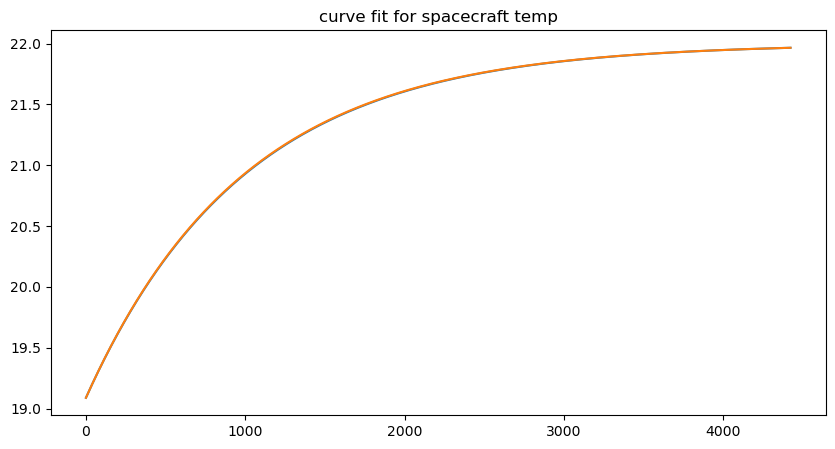

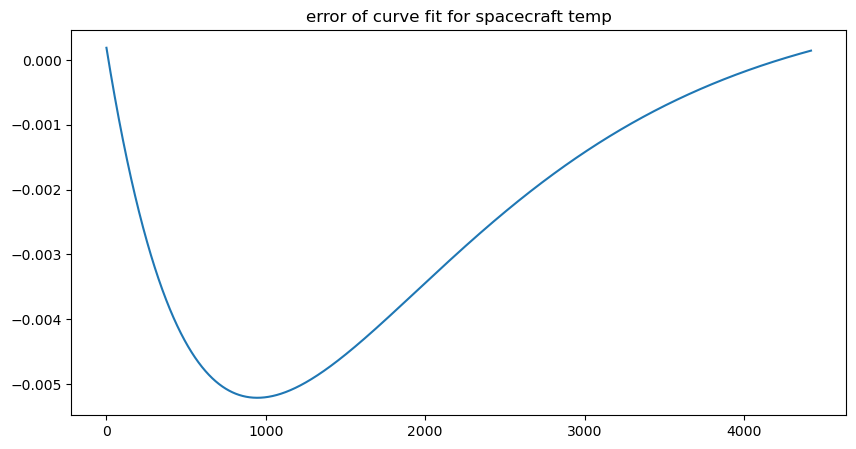

In [218]:
#lets try axtracting a curve from temp, to see if we'll be able to use the method for the noisier darks

sample_pass = dete_temp[down_start_temp:down_end_temp,:]


#we need a function to fit the shape of a-exp(b/(x-c))
def heat_curve(x, a, b, c, d):
    return a*np.exp(b*x+c)+d

def minimization(args):
    a,b,c,d = args[0],args[1],args[2],args[3]
    array1 = sample_pass[:,1]
    array2 = heat_curve(sample_pass[:,0]-sample_pass[0,0],a,b,c,d)
    dist = array1-array2
    return sum(dist**2)

# ans = sp.optimize.minimize(minimization,np.asarray([30,sample_pass[0,0]+1e9/1e9,1/1e9]),method='COBYLA',tol=1e-3)
ans = sp.optimize.minimize(minimization,np.asarray([-1, -1/9.94e2, 9.49094e5+15.1685, 21.999]),method='Powell')
mp.figure(figsize=(10,5))
mp.title('curve fit for spacecraft temp')
mp.plot(sample_pass[:,0]-sample_pass[0,0], sample_pass[:,1])
mp.plot(sample_pass[:,0]-sample_pass[0,0], heat_curve(sample_pass[:,0],-1, -1/9.94e2, 9.49094e5+15.1685, 21.999))
# #ok, so I'm able to improve the optimization by hand, by looking at the graph, so I'm going to say that the optimize function isn't doing much here.
# 
# print(ans)

mp.figure(figsize=(10,5))
mp.title('error of curve fit for spacecraft temp')
mp.plot(sample_pass[:,0]-sample_pass[0,0], sample_pass[:,1]-heat_curve(sample_pass[:,0],-1, -1/9.94e2, 9.49094e5+15.1685, 21.999))

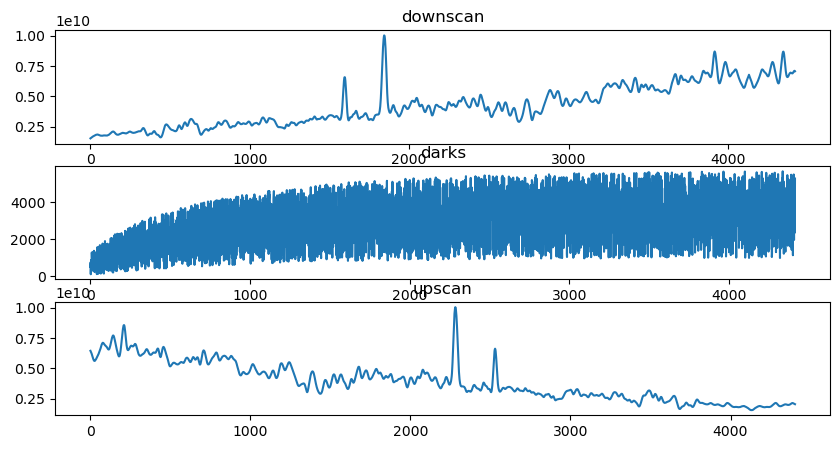

In [134]:
#Temp correction


fig, axs = mp.subplots(3,1, figsize=(10,5))
axs[0].plot(inst_tele[down_start:down_end,0]-down_start_time, inst_tele[down_start:down_end,2])
axs[0].title.set_text('downscan')
axs[1].plot(inst_tele[dark_start:dark_end,0]-dark_start_time, inst_tele[dark_start:dark_end,2])
axs[1].title.set_text('darks')
axs[2].plot(inst_tele[up_start:up_end,0]-up_start_time, inst_tele[up_start:up_end,2])
axs[2].title.set_text('upscan')

In [133]:
ans

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2221.7350413079294
       x: [-1.018e+00 -4.192e+20  9.491e+05  2.137e+01]
     nit: 3
     jac: [ 0.000e+00 -0.000e+00  0.000e+00 -1.099e-03]
    nfev: 29
    njev: 3

In [117]:
ans.x[0]+0.02,ans.x[1]+2.9e7,1/(ans.x[2]-5.5e6)

(nan, nan, nan)

In [118]:
down_start = np.where (inst_tele[:,0]>=down_start_time)[0][0]

In [119]:
down_start

29157

In [120]:
down_end = np.where (inst_tele[:,0]>=down_end_time)[0][0]

In [121]:
down_end

31684